In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('C:\\Users\\amrit\\Documents\\epilepsia\\iEEG_STC\\iEEG_STC')
import reader
from reader import ECOGReader


import pandas as pd
import numpy as np
from scipy import stats
import mne
import os

from scipy import signal
import tqdm
from tqdm import tqdm, tqdm_notebook


import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from datetime import datetime, timedelta


import torch
import seaborn as sns
from scipy.spatial import distance
from operator import add
from torchvision import datasets, models, transforms

from sklearn.preprocessing import StandardScaler


import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import hilbert
import warnings

# Disable warnings
warnings.filterwarnings("ignore")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def clockplot(hourly_mean, hourly_std, seizures, s1, s2):
    ax = plt.subplot(111, polar=True)

    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    width = np.deg2rad(15)

    colors = plt.cm.viridis_r(hourly_mean / max(hourly_mean))

    num_hours = len(hourly_mean)
    theta = np.linspace(0, 2 * np.pi, num_hours, endpoint=False)

    hourly_mean = np.append(hourly_mean, hourly_mean[0])
    hourly_std = np.append(hourly_std, hourly_std[0])
    theta = np.append(theta, 2 * np.pi)

    # Plot circular wedges as error bars
    for i in range(num_hours):
        ax.fill_between([theta[i] - width / 2, theta[i] + width / 2],
                        hourly_mean[i] - hourly_std[i],
                        hourly_mean[i] + hourly_std[i],
                        color=colors[i], alpha=0.8)

    last_color = plt.cm.viridis_r(hourly_mean[-1] / max(hourly_mean))

    hours = ['0', '3', '6', '9', '12', '15', '18', '21']
    ax.set_xticklabels(hours)

    ax.set_yticklabels([])

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=min(hourly_mean), vmax=max(hourly_mean)))
    sm._A = []
    cbar = plt.colorbar(sm, pad=0.1)
    cbar.set_label(s2, rotation=270, labelpad=15)

    ax.plot(theta, hourly_mean, color='black', linestyle='--', linewidth=2)

    for time in seizures:
        ax.axvline(x=np.deg2rad((pd.Timestamp(time).hour + (pd.Timestamp(time).minute) / 60) * 15),
                    linestyle='--', color='red', alpha=0.5)

    ax.set_title(s1)

    plt.show()




In [3]:
import numpy as np
from scipy.stats import spearmanr


def cosine_daily_corr(df, mytest):
    datetime_index = df.datetime_column

    # Define the range of phase values from 0 to 2*pi with pi/20 intervals
    phase_values = np.arange(0, 2 * np.pi, np.pi / 200)

    # Initialize variables to store the maximum correlation and corresponding phase
    max_correlation = 0
    optimal_phase = None

    # Calculate the cosine values at the same timestamps
    frequency = 2 * np.pi / 24  # Frequency for hourly oscillation (1 cycle in 24 hours)
    amplitude = 1.0  # Amplitude of the cosine wave

    for phase in phase_values:
        # Calculate the cosine values at the same timestamps as df_cosine
        cosine_values = amplitude * np.cos(frequency * np.arange(len(datetime_index)) + phase)

        # Calculate the correlation between 'auto' and the generated cosine values
        correlation, pp = scipy.stats.pearsonr(df[mytest], cosine_values)
        #correlation = np.corrcoef(df[mytest], cosine_values)[0]

        # Update the maximum correlation and optimal phase
        if np.abs(correlation) > np.abs(max_correlation):
            max_correlation = correlation
            optimal_phase = pp

    
    return max_correlation, optimal_phase

In [4]:
def is_within_interval(value, intervals):
    for interval in intervals:
        if interval * 120 <= value < (interval + 1) * 120:
            return True
    return False

def nan_mean(dd, n ,m, sys):
    [n_, m_] = np.shape(dd)
    n_l = np.random.permutation(n_)[:n]
    m_l = np.random.permutation(m_)[:m]

    dd_temp = dd[n_l, :][:, m_l]
    
    if sys == 1:
        to_return = np.mean(dd_temp[~np.isnan(dd_temp)].flatten())
    else:
        to_return = np.median(dd_temp[~np.isnan(dd_temp)].flatten())
    
    return to_return
def nan_mean2(dd, n):
    n_ = len(dd)
    n_l = np.random.permutation(n_)[:n]
    
    dd_temp = dd[n_l]
    return np.mean(dd_temp[~np.isnan(dd_temp)])


def subsample_spikes(df, duration):
    to_return = np.zeros((9,))
    to_return[0] = np.sum(df['numChannels']) /(duration)
    
    n_sampling = [10, 30, 50, 70] 
    
    
    
    
    for i in range(4):
        max_value = max(max(numbers) for numbers in df['channels'])
        top_val = int(np.ceil(max_value*(n_sampling[i]/100)))
        list_to_include = np.random.permutation(max_value)[:top_val]
        mask = [a_channel in list_to_include for a_channel in df['channels'] ]
        df_filtered = df[mask]
        to_return[i+1] =  np.sum(df_filtered['numChannels']) /(duration)
    

    
    for i in range(4):
        t_time = int(np.ceil(duration/120)) ### 2 min segs
        to_include = np.random.permutation(t_time)[:int(np.ceil(t_time*n_sampling[i]/100))]
        mask = df['spikeStart_sec'].apply(lambda x: is_within_interval(x, to_include))
        df_filtered = df[mask]
        to_return[i+5] = np.sum(df_filtered['numChannels']) /(int(3600*n_sampling[i]/100))
        
    return to_return
    

def spike2min(df, dur):
    
    interval_size = 120

    # Create intervals
    df['interval'] = pd.cut(df['spikeStart_sec'], bins=range(0, int(np.ceil(dur + interval_size)), interval_size), right=False)

    # Group by intervals and sum numChannels
    result = df.groupby('interval')['numChannels'].sum().reset_index()
    
    return np.array(result['numChannels']/interval_size)

def subspike(df, mask, dur):
    to_return = np.zeros((11,))
    
    total = spike2min(df, dur)
    
    if len(total) > len(mask):
        mask = mask + [mask[-1]]
    
    to_return[0] = np.median(total[mask])
    
    max_value = max(max(numbers) for numbers in df['channels'])
    list_to_include = np.random.permutation(max_value)[0]
    mask2 = [list_to_include in a_channel for a_channel in df['channels'] ]
    df_filtered = df[mask2]
    to_return[1] = np.median(spike2min(df_filtered, dur)[mask])
    
    n_sampling = [10, 30, 50, 70] 

    for i in range(4):
        max_value = max(max(numbers) for numbers in df['channels'])
        top_val = int(np.ceil(max_value*(n_sampling[i]/100)))
        list_to_include = np.random.permutation(max_value)[:top_val]
        mask2 = [a_channel in list_to_include for a_channel in df['channels'] ]
        df_filtered = df[mask2]
        to_return[i+2] = np.median(spike2min(df_filtered, dur)[mask])
    
    xxx = np.random.permutation(len(total))[0]
    to_return[6] = total[xxx]
    for i in range(4):
        to_include = np.random.permutation(len(total))[:int(np.ceil(len(total)*n_sampling[i]/100))]
        to_return[i+7] = np.median(total[to_include])
        
    return to_return
    
    
def subsample(data , sys ):
    [n,m] = np.shape(data)
    
    n_sampling = [10, 30, 50, 70] 
    to_return = np.zeros((11,))
    
    to_return[0] = nan_mean(data, n, m, sys)
    to_return[1] = nan_mean(data, n, 1, sys)
    
    
    for i in range(4):
        int_samp = int(np.ceil(m*(n_sampling[i]/100)))
        to_return[i+2] = nan_mean(data, n, int_samp, sys)
    
    to_return[6] = nan_mean(data, 1, m, sys)
    for i in range(4):
        int_samp = int(np.ceil(n*(n_sampling[i]/100)))
        to_return[i+7] = nan_mean(data, int_samp, m , sys)
        
        
    return to_return


def subsample_syn(data):
    n = len(data)
    n_sampling = [10, 30, 50, 70]
    to_return = np.zeros((6,))
    
    to_return[0] = nan_mean2(data, n)
    to_return[1] = nan_mean2(data, 1)
    
    
    for i in range(4):
        int_samp = int(np.ceil(n*(n_sampling[i]/100)))
        to_return[i+2] = nan_mean2(data, int_samp)

    return to_return



def subsample_syn2(data):
    [p, q] = np.shape(data)
    to_return = np.zeros((5,))
    
    for i in range(5):
        to_return[i] = nan_mean2(data[:,i], p)

    return to_return



# Define a function to check if a timestamp is within 5 minutes of any seizure time
def is_within_5_minutes(timestamp, seizure_times):
    for seizure_time in seizure_times['onset']:
        if abs((timestamp - seizure_time)) <= 300:  # 300 seconds = 5 minutes
            return True
    return False


def exclude_intervals_within_seizure(seizure_times, start_time, duration_seconds):
    # Initialize an array of exclusion flags (False initially)
    num_intervals = int(np.floor(duration_seconds / 120))
    exclusion_flags = [True] * int(num_intervals)
    
    # Calculate the interval end times
    interval_end_times = [start_time + timedelta(seconds=i * 120) for i in range(int(num_intervals))]
    
    # Iterate through the intervals
    for i, interval_end in enumerate(interval_end_times):
        # Check if any seizure time falls within 5 minutes of the interval
        within_5_min = any(abs((seizure_times['onset'] - interval_end.timestamp())) <= 300)
        if within_5_min:
            exclusion_flags[i] = False
    
    return exclusion_flags

def count_seizures_within_interval(seizure_times, start_time, duration_seconds):
    interval_end = (start_time + timedelta(seconds=duration_seconds)).timestamp()
    count = 0
    for i in seizure_times['onset']:
        if (i >= start_time.timestamp()) & (i <= interval_end):
            count +=1
    return count


def subj_extractor(seizure_file, duration_file, date_time_file, subj_files_path, data_path_spike, data_path_all):
    st = pd.read_csv(seizure_file)
    seiz = st['onset_ts']
    onset_dt = sort([datetime.fromtimestamp(int(o)) for o in seiz])
    
    
    bands = ['theta', 'alpha', 'beta', 'gamma', 'broad', 'theta_psd', 'alpha_psd', 'beta_psd', 'gamma_psd', 'broad_psd']
    
    
    n_sampling = [10, 30, 50, 70] 
    
    subj_files = np.genfromtxt(subj_files_path, dtype= str)
    n_files = len(subj_files)
    duration = np.loadtxt(duration_file)
    df= pd.read_csv(date_time_file, parse_dates=['datetime_column'])    
    
    
    spikes_all = np.zeros((11, n_files))
    auto_all = np.zeros((11, 10, n_files))
    var_all = np.zeros((11, 10, n_files))
    syn_all = np.zeros((6, 10, n_files))
    dist_all = np.zeros((6, 10, n_files ))
    
    
    for i in range(n_files):
        
        ######SPIKES
        fullp = data_path_spike + subj_files[i] + '.csv'
        single_pd = pd.read_csv(fullp)

        start_date = df['datetime_column'][i]
        
        
        mask_seizure = exclude_intervals_within_seizure(st, start_date, duration[i])

        
        
        single_pd['datetime'] = [timedelta(seconds=s) + start_date for s in single_pd['spikeStart_sec']]

        # Convert the string lists to actual lists of numbers
        single_pd['channels'] = single_pd['channels'].apply(lambda x: [int(num) for num in x.strip('[]').split(',')])
        
       
        # Find the maximum value across all numbers
        spikes_all[:,i] = subspike(single_pd, mask_seizure, duration[i])

        fullbase = data_path_all + subj_files[i] 
        
        
        

    
        for iter_n, b in enumerate(bands[:5]):
            
         ######VAR + AUTO           
            full_path_var = fullbase + '_' + b + '_variance.txt'
            full_path_varpsd = fullbase + '_' + b + '_variance_psd.txt'
            var = np.loadtxt(full_path_var)
            n = len(var)
            var = var[mask_seizure]
            var_psd = np.loadtxt(full_path_varpsd)[:n]
            var_psd = var_psd[mask_seizure]
            
            full_path_lag = fullbase + '_' + b + '_lag_times.txt'
            full_path_lagpsd = fullbase + '_'  + b + '_lag_times_psd.txt'
            auto = np.loadtxt(full_path_lag)
            n = len(auto)
            auto = auto[mask_seizure]
            auto_psd = np.loadtxt(full_path_lagpsd)[:n]
            auto_psd = auto_psd[mask_seizure]
            
           
                
            auto_all[:, iter_n, i] = subsample(auto, 1)
            auto_all[:, iter_n+5, i] = subsample(auto_psd, 1)
            var_all[:, iter_n, i] =  subsample(var, 0)
            var_all[:, iter_n+5, i] = subsample(var_psd, 0)
            
        ######SYN
        
            full_path_syn = fullbase + '_' + b + '_syn.txt'
            full_path_synpsd = fullbase + '_' + b + '_syn_psd.txt'
            syn = np.loadtxt(full_path_syn)
            n = len(syn)
            syn = syn[mask_seizure]
            syn_psd = np.loadtxt(full_path_synpsd)[:n]
            syn_psd = syn_psd[mask_seizure]
                    
            syn_all[:, iter_n, i] = subsample_syn(syn[:, -1])
            syn_all[:, iter_n+5, i] = subsample_syn(syn_psd[:, -1])
        
            

        ######SPATIAL
                    
            full_path_dist = fullbase + '_' + b + '_dist.txt'
            full_path_distpsd = fullbase + '_' + b + '_dist_psd.txt'
            dist = np.loadtxt(full_path_dist)
            n = len(dist)
            dist = dist[mask_seizure]
            dist_psd = np.loadtxt(full_path_distpsd)[:n]
            dist_psd = dist_psd[mask_seizure]
        

            dist_all[:, iter_n, i] = subsample_syn(dist)
            dist_all[:, iter_n+5, i] = subsample_syn(dist_psd)
         

    df['hour'] = df['datetime_column'].dt.hour
                    
                    
    df['spike'] = spikes_all[0]
    df['spike_1s'] = spikes_all[1]
    df['spike_10s'] = spikes_all[2]
    df['spike_30s'] = spikes_all[3]
    df['spike_50s'] = spikes_all[4]
    df['spike_70s'] = spikes_all[5]
    
    df['spike_1t'] = spikes_all[6]
    df['spike_10t'] = spikes_all[7]
    df['spike_30t'] = spikes_all[8]
    df['spike_50t'] = spikes_all[9]
    df['spike_70t'] = spikes_all[10]

    subsamp_names = ['', '_1s', '_10s', '_30s', '_50s', '_70s', '_1t', '_10t', '_30t', '_50t', '_70t']
    subsamp_names_dist = ['', '_1t','_10t', '_30t', '_50t', '_70t']                
    for i in range(10):
        for j in range(11):
            df['var' + bands[i] + subsamp_names[j]] = var_all[j,i,:]
            df['auto'  + bands[i] + subsamp_names[j]] = auto_all[j,i,:]
            
    
        for j in range(6):
            df['dist' + bands[i] + subsamp_names_dist[j]] = dist_all[j,i,:]
            df['syn' + bands[i] + subsamp_names_dist[j]] = syn_all[j,i,:]
    
    
        # Calculate the time difference in seconds from the first datetime
    df['time_difference'] = (df['datetime_column'] - df['datetime_column'].iloc[0]).dt.total_seconds()

    # Calculate the cosine values with a period of 1 day
    df['cosine_column'] = np.cos(2 * np.pi * df['time_difference'] / 86400)  # 86400 seconds in a day

    
    
        # Create a mask based on the duration array
    mask = duration >= 2880

    # Apply the mask to filter the DataFrame
    filtered_df = df[mask]
    
    
    
    
    return filtered_df, onset_dt
            
    

In [5]:
from __future__ import division
from pylab import *
from numpy import *
import array, sys
from scipy.signal import *
from scipy.signal import freqz
from scipy import fftpack
from scipy.signal import hilbert
import cmath
from scipy.signal import filtfilt
 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import circmean, circstd
import pycircstat as circstats
from scipy.stats import circmean, circvar, circstd
from scipy.stats import vonmises

def extend_array(arr, target_length=65):
    if len(arr) < target_length:
        last_digit = arr[-1]
        extension = np.full(target_length - len(arr), last_digit)
        arr = np.concatenate((arr, extension))
    return arr



### determine the phase of a signal
def myphase(a):
    a-= mean(a)
    b= hilbert(a)
    b= np.arctan2(np.imag(b),np.real(a))
    return b



def is_within_bin(angle, bin_range):
    start, end = bin_range
    if start <= end:
        return start <= angle <= end
    else:
        return np.logical_or((start <= angle) & (angle <= math.pi), (-math.pi <= angle) & (angle <= end))


def identify_outliers(df, mytest):
    timeseries = df[mytest]
    # Calculate the mean and standard deviation of the data
    mean = np.mean(timeseries)
    std_dev = np.std(timeseries)

    # Define the number of standard deviations beyond which data points are considered outliers
    num_std_devs = 3

    # Calculate the lower and upper bounds for outlier removal
    lower_bound = mean - num_std_devs * std_dev
    upper_bound = mean + num_std_devs * std_dev

    outlier_mask = (timeseries >= lower_bound) & (timeseries <= upper_bound)

    return outlier_mask
    
def PLV_calc(df, mytest, seizure_times):
    ###filter out some outliers
    

    
    # Convert datetime_column to seconds
    df['time_seconds'] = (df['datetime_column'] - df['datetime_column'].min()).dt.total_seconds()

    # Define a regular time grid with one-hour intervals based on your data
    t_regular = pd.date_range(start=df['datetime_column'].min(), end=df['datetime_column'].max(), freq='1H')

    
    
    
    # Convert regular time grid to seconds
    t_regular_seconds = (t_regular - t_regular.min()).total_seconds()
    
    
    mask = identify_outliers(df, mytest)
    df = df[mask]
    

    # Interpolate the 'spike' column to the regular time grid using seconds
    interpolator = interp1d(df['time_seconds'], df[mytest], kind='linear', fill_value='extrapolate')
    data_interp = interpolator(t_regular_seconds)

    
    # Define the sampling frequency (one sample per hour)
    fs = 1.0 / 3600.0  # Sampling frequency in samples per second (1/3600 hours)
    
    # Create a StandardScaler instance
    scaler = StandardScaler()
    # Fit the scaler to your data and transform it to have mean 0 and std 1
    normalized_signal = scaler.fit_transform(data_interp.reshape(-1, 1)).flatten()
    
        # Calculate the periodogram using Welch method
    frequencies, psd = signal.welch(normalized_signal, fs=fs, nperseg=128, noverlap=64)
    periods_hours = (1 / frequencies) / 3600
        
    # Find the values of the PSD at the intersection points
    index_24_hours = np.argmin(np.abs(periods_hours - 24))
    index_12_hours = np.argmin(np.abs(periods_hours - 12))
    psd_peak = [ np.log(psd[index_12_hours]) , np.log(psd[index_24_hours])]
    
    
    
    # Define the desired cutoff frequencies as fractions of the Nyquist frequency
    lowcut = 1.0 / 30.0  # Lower cutoff frequency for 24 hours
    highcut = 1.0 / 2.0  # Upper cutoff frequency for 12 hours

    order = 1
    # Design the bandpass filter using Butterworth filter design
    b, a = signal.butter(order, [lowcut, highcut], btype="band")

    # Apply the bandpass filter to your data
    filtered_data = signal.filtfilt(b, a, data_interp, padtype='constant', padlen=50)  # Adjust padlen as needed
    

    phase = myphase(filtered_data)
    
    onset_seconds = [(dt - t_regular.min()).total_seconds() for dt in seizure_times]
    interpolated_phase = np.interp(onset_seconds, t_regular_seconds, phase)

    

    # Calculate the sum of e^(i*interpolated_phase) for each onset datetime point
    result_sum = np.sum(np.exp(1j * interpolated_phase))
    

    # Calculate the phase locking value (PLV)
    plv = np.abs(np.real(result_sum / len(onset_dt)))
    
    xxx = int(np.floor(len(interpolated_phase)*0.9))
    interpolated_phase_train = interpolated_phase[:xxx]
    interpolated_phase_test = interpolated_phase[xxx:]
    
    ss = onset_seconds[xxx]
    s_indx = np.argmin(np.abs(t_regular_seconds - ss))

        # Calculate the mean and standard deviation of the data
        
    kappa = 1/circvar(interpolated_phase_train)
    mu = circmean(interpolated_phase_train)
        
    probability_values = np.array([vonmises.pdf(x, kappa,  loc=mu) for x in interpolated_phase_test])
    probability_timeseries = np.array([vonmises.pdf(x, kappa, loc=mu) for x in phase[s_indx:]])

    

  # probability_values = norm.pdf(interpolated_phase, loc=0, scale=std_dev_data)
  #  probability_timeseries = norm.pdf(phase[s_indx:], loc=0, scale=std_dev_data)

    #plt.plot(probability_timeseries)

    highest_value = max(probability_timeseries)
    threshold_values = np.flip(np.linspace(0, highest_value,100))

    count_above_threshold_time = np.zeros((len(threshold_values)+1,))
    count_above_threshold_seiz = np.zeros((len(threshold_values)+1,))


    for i,threshold in enumerate(threshold_values):
        count_above_threshold_time[i+1] = sum(1 for element in probability_timeseries if element > threshold) / len(probability_timeseries)
        count_above_threshold_seiz[i+1] = sum(1 for element in probability_values if element > threshold) / len(probability_values)
   
    count_above_threshold_time = np.append(count_above_threshold_time, 1)
    count_above_threshold_seiz = np.append(count_above_threshold_seiz, 1)
        
    auc = np.trapz(count_above_threshold_seiz,count_above_threshold_time)    
    
    return extend_array(psd), plv, auc, probability_timeseries, probability_values

def AED_corr(df, mytest, dosage):
        
    mask = identify_outliers(df, mytest)
    df = df[mask]
    
    
#    sumDDD_values = []
    
#    sumDDD_values = []

    
#    for index, row in df.iterrows():
        # Extract the day from the datetime row
#        day = row['datetime_column'].date() + pd.Timedelta(hours=8)
        # Check if the day exists in 'aed_df'
#        if day in aed_df['startdate'].dt.date.values:
            # Get the corresponding 'sumDDD' value from 'aed_df'
#            sumDDD_value = aed_df.loc[aed_df['startdate'].dt.date == day, 'sumDDD'].values[0]
#            sumDDD_values.append(sumDDD_value)
#        else:
            # If the day is not found in 'aed_df', append NaN or any other default value
#            sumDDD_values.append(None)

    
    
    # Create an empty list to store the mean_mytest values
    mean_mytest_values = []

    # Loop over days in 'aed_df'
    for day in aed_df['startdate'].dt.date:
        # Filter 'df' to include only data for the current day
        filtered_df = df[df['datetime_column'].dt.date + pd.Timedelta(hours=8) == day]

        # Calculate the mean of 'mytest' values for the current day
        mean_mytest = filtered_df[mytest].mean()

        # Append the mean_mytest to the list
        mean_mytest_values.append(mean_mytest)

    
  #  correlation = np.corrcoef(mean_mytest_values, aed_df['sumDDD'])[0, 1]
    correlation, _ = spearmanr(mean_mytest_values, aed_df['sumDDD'])
    
    
    
    # Add the 'sumDDD' values to the original DataFrame
   # df['sumDDD'] = sumDDD_values

    # Drop rows where 'sumDDD' is NaN (not found in 'aed_df')
   # df.dropna(subset=['sumDDD'], inplace=True)

    # Calculate the correlation between 'sumDDD' and 'spike'
  #  correlation = df['sumDDD'].corr(df[mytest])

    return correlation





############################# Average Metrics by the whole day 

In [6]:
def thresholdthis(a_t, b_t):
    highest_value = np.max(a_t)


    
    threshold_values = np.flip(np.linspace(0, highest_value,100))

    count_above_threshold_time = np.zeros((len(threshold_values)+1,))
    count_above_threshold_seiz = np.zeros((len(threshold_values)+1,))


    for i,threshold in enumerate(threshold_values):
        count_above_threshold_time[i+1] = sum(1 for element in a_t if element > threshold) / len(a_t)
        count_above_threshold_seiz[i+1] = sum(1 for element in b_t if element > threshold) / len(b_t)

    count_above_threshold_time = np.append(count_above_threshold_time, 1)
    count_above_threshold_seiz = np.append(count_above_threshold_seiz, 1)
        
    # Calculate the area under the curve (AUC)
    area_under_curve = np.trapz(count_above_threshold_seiz,count_above_threshold_time)
    return area_under_curve, count_above_threshold_seiz, count_above_threshold_time

def normalizeprob(a, b):
    pwr = np.sum(a)
    return a/pwr, b/pwr
    


In [8]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


import datetime
from datetime import datetime

allpats = ['115' ,'139', '253','264', '273', '375', '442','548', '565', '583', '590', '620','818', '862', '916', '922', '958', '970', '1073', '1077', '1096', '1084','1146']

subsamp_names = ['', '_1s', '_10s', '_30s', '_50s', '_70s', '_1t', '_10t', '_30t', '_50t', '_70t']
subsamp_names_dist = ['', '_1t','_10t', '_30t', '_50t', '_70t']   
bands = ['theta', 'alpha', 'beta', 'gamma', 'broad', 'theta_psd', 'alpha_psd', 'beta_psd', 'gamma_psd', 'broad_psd']


df_list = []
onset_list = []


for n_pat, pat in enumerate(allpats):
    print(f'Starting Pat #: {pat}')
    base_path = f'C:\\Users\\amrit\\Documents\\epilepsia\\dataset_full\\{pat}'

    seizure_file = f'{base_path}\\pat{pat}_seizures.csv'
    duration_file = f'{base_path}\\duration_{pat}.txt'
    date_time_file = f'{base_path}\\datetime_ieeg_{pat}.csv'
    data_path_spike = f'{base_path}\\PROCESSED\\pat{pat}_'
    data_path_all = f'{base_path}\\AUTOVARSYNDIST_JAN\\pat{pat}_'
    subj_files_path = f'{base_path}\\all{pat}.txt'

    aed_path = f'{base_path}\\pat{pat}_AED.csv'
    aed_df = pd.read_csv(aed_path)


    seizure_df = pd.read_csv( seizure_file)
    aed_df['startdate'] = pd.to_datetime(aed_df['startdate'])


    seizure_df['onset_ts'] = [datetime.fromtimestamp(int(o)) for o in seizure_df['onset_ts']]
    seizure_df['offset_ts'] = [datetime.fromtimestamp(int(o)) for o in seizure_df['offset_ts']]

    df, onset_dt = subj_extractor(seizure_file, duration_file, date_time_file, subj_files_path, data_path_spike, data_path_all)



    df_list.append(df)
    onset_list.append(onset_dt)

Starting Pat #: 115
Starting Pat #: 139
Starting Pat #: 253
Starting Pat #: 264
Starting Pat #: 273
Starting Pat #: 375
Starting Pat #: 442
Starting Pat #: 548
Starting Pat #: 565
Starting Pat #: 583
Starting Pat #: 590
Starting Pat #: 620
Starting Pat #: 818
Starting Pat #: 862
Starting Pat #: 916
Starting Pat #: 922
Starting Pat #: 958
Starting Pat #: 970
Starting Pat #: 1073
Starting Pat #: 1077
Starting Pat #: 1096
Starting Pat #: 1084
Starting Pat #: 1146


In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


import datetime
from datetime import datetime

allpats = ['115' ,'139', '253','264', '273', '375', '442','548', '565', '583', '590', '620','818', '862', '916', '922', '958', '970', '1073', '1077', '1096', '1084', '1146']

subsamp_names = ['', '_10s', '_30s', '_50s', '_70s', '_10t', '_30t', '_50t', '_70t']
subsamp_names_dist = ['', '_10t', '_30t', '_50t', '_70t'] 
bands = ['theta', 'alpha', 'beta', 'gamma', 'broad', 'theta_psd', 'alpha_psd', 'beta_psd', 'gamma_psd', 'broad_psd']


df_list = []
onset_list = []


n_times = 10

plvspikes = np.zeros((len(allpats),9, n_times))
plvvar = np.zeros((len(allpats),10, 9, n_times))
plvauto = np.zeros((len(allpats),10, 9, n_times))
plvsyn = np.zeros((len(allpats),10, 9, n_times))
plvdist = np.zeros((len(allpats),10, 5,n_times))
plvcos = np.zeros((len(allpats),n_times))


aucspikes = np.zeros((len(allpats),9, n_times))
aucvar = np.zeros((len(allpats),10, 9, n_times))
aucauto = np.zeros((len(allpats),10, 9, n_times))
aucsyn = np.zeros((len(allpats),10, 9, n_times))
aucdist = np.zeros((len(allpats),10, 5, n_times))
auccos = np.zeros((len(allpats),n_times))


aedspikes = np.zeros((len(allpats),9 , n_times))
aedvar = np.zeros((len(allpats),10, 9, n_times))
aedauto = np.zeros((len(allpats),10, 9, n_times))
aedsyn = np.zeros((len(allpats),10, 9, n_times))
aeddist = np.zeros((len(allpats),10, 5, n_times))
aedcos = np.zeros((len(allpats), n_times))


for kk in range(n_times):
    print(f'Starting LOOP #: {kk+1}')
    for n_pat, pat in enumerate(allpats):

        base_path = f'C:\\Users\\amrit\\Documents\\epilepsia\\dataset_full\\{pat}'

        seizure_file = f'{base_path}\\pat{pat}_seizures.csv'
        duration_file = f'{base_path}\\duration_{pat}.txt'
        date_time_file = f'{base_path}\\datetime_ieeg_{pat}.csv'
        data_path_spike = f'{base_path}\\PROCESSED\\pat{pat}_'
        data_path_all = f'{base_path}\\AUTOVARSYNDIST_JAN\\pat{pat}_'
        subj_files_path = f'{base_path}\\all{pat}.txt'

        aed_path = f'{base_path}\\pat{pat}_AED.csv'
        aed_df = pd.read_csv(aed_path)


        seizure_df = pd.read_csv( seizure_file)
        aed_df['startdate'] = pd.to_datetime(aed_df['startdate'])


        seizure_df['onset_ts'] = [datetime.fromtimestamp(int(o)) for o in seizure_df['onset_ts']]
        seizure_df['offset_ts'] = [datetime.fromtimestamp(int(o)) for o in seizure_df['offset_ts']]

        df, onset_dt = subj_extractor(seizure_file, duration_file, date_time_file, subj_files_path, data_path_spike, data_path_all)

        for i in range(9):
            plvspikes[n_pat,i,kk] , aucspikes[n_pat,i, kk]  = PLV_calc(df.copy(), 'spike' + subsamp_names[i] ,onset_dt)
            aedspikes[n_pat, i, kk] = AED_corr(df.copy(), 'spike' + subsamp_names[i], aed_df.copy())


        for i in range(10):
            for j in range(9):
                plvvar[n_pat, i,j,kk] , aucvar[n_pat, i,j,kk] = PLV_calc(df.copy(),'var' + bands[i] + subsamp_names[j], onset_dt)
                plvauto[n_pat, i,j,kk], aucauto[n_pat, i,j,kk]  = PLV_calc(df.copy() ,'auto'  + bands[i] + subsamp_names[j], onset_dt)
                plvsyn[n_pat, i, j,kk] , aucsyn[n_pat, i, j,kk]   = PLV_calc(df.copy(), 'syn' + bands[i] + subsamp_names[j], onset_dt) 


                aedvar[n_pat, i,j, kk] = AED_corr(df.copy(), 'var' + bands[i] + subsamp_names[j], aed_df.copy())
                aedauto[n_pat, i,j,kk] =AED_corr(df.copy(), 'auto' + bands[i] + subsamp_names[j], aed_df.copy())
                aedsyn[n_pat, i,j,kk] =AED_corr(df.copy(), 'syn' + bands[i] + subsamp_names[j], aed_df.copy())


            for j in range(5):
                plvdist[n_pat, i, j,kk], aucdist[n_pat, i, j, kk] = PLV_calc(df.copy(), 'dist' + bands[i] + subsamp_names_dist[j], onset_dt) 
                aeddist[n_pat, i,j,kk] =AED_corr(df.copy(), 'dist' + bands[i] + subsamp_names_dist[j], aed_df.copy())



        plvcos[n_pat,kk] , auccos[n_pat,kk] = PLV_calc(df.copy(), 'cosine_column'  , onset_dt)
        aedcos[n_pat,kk] = AED_corr(df.copy(),'cosine_column' , aed_df.copy())
        df_list.append(df)
        onset_list.append(onset_dt)


In [311]:
np.save('plvspikes.npy', plvspikes)
np.save('plvvar.npy', plvvar)
np.save('plvauto.npy', plvauto)
np.save('plvsyn.npy', plvsyn)
np.save('plvdist.npy', plvdist)
np.save('plvcos.npy', plvcos)


In [312]:
np.save('aucspikes.npy', aucspikes)
np.save('aucvar.npy', aucvar)
np.save('aucauto.npy', aucauto)
np.save('aucsyn.npy', aucsyn)
np.save('aucdist.npy', aucdist)
np.save('auccos.npy', auccos)


In [313]:
np.save('psdspikes.npy', psdspikes)
np.save('psdvar.npy', psdvar)
np.save('psdauto.npy', psdauto)
np.save('psdsyn.npy', psdsyn)
np.save('psddist.npy', psddist)


In [18]:
plvspikes = np.load('plvspikes.npy')
plvvar = np.load('plvvar.npy')
plvauto = np.load('plvauto.npy')
plvsyn = np.load('plvsyn.npy')
plvdist = np.load('plvdist.npy')


aucspikes = np.load('aucspikes.npy')
aucvar = np.load('aucvar.npy')
aucauto = np.load('aucauto.npy')
aucsyn = np.load('aucsyn.npy')
aucdist = np.load('aucdist.npy')

psdspikes = np.load('psdspikes.npy')
psdvar = np.load('psdvar.npy')
psdauto = np.load('psdauto.npy')
psdsyn = np.load('psdsyn.npy')
psddist = np.load('psddist.npy')



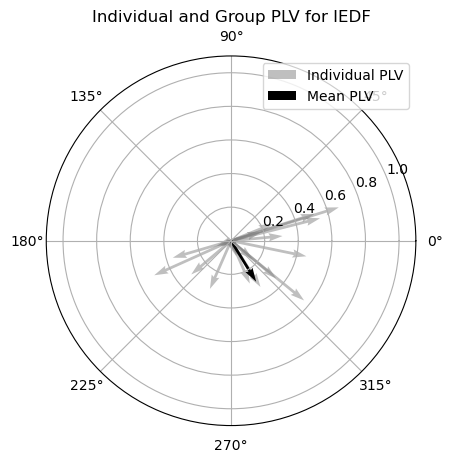

In [30]:



# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_ylim(0, 1.1)  # Set the radial range from 0 to 1.2


cccc=0
for phase, magnitude in zip(angles, mags):
    if cccc == 0:
        ax.quiver(0, 0, np.angle(np.exp(1j * phase)), magnitude, angles='xy', scale=1, scale_units='xy', color='gray', alpha=0.5, label = 'Individual PLV')
    else:
        ax.quiver(0, 0, np.angle(np.exp(1j * phase)), magnitude, angles='xy', scale=1, scale_units='xy', color='gray', alpha=0.5)
    cccc=1

# Plot a black line for the average phase
ax.quiver(0, 0, circmean(angles), np.mean(mags), angles='xy', scale=1, scale_units='xy', color='black', label = 'Mean PLV')


# Set the title
plt.title('Individual and Group PLV for IEDF')
plt.legend()
# Show the plot
plt.show()

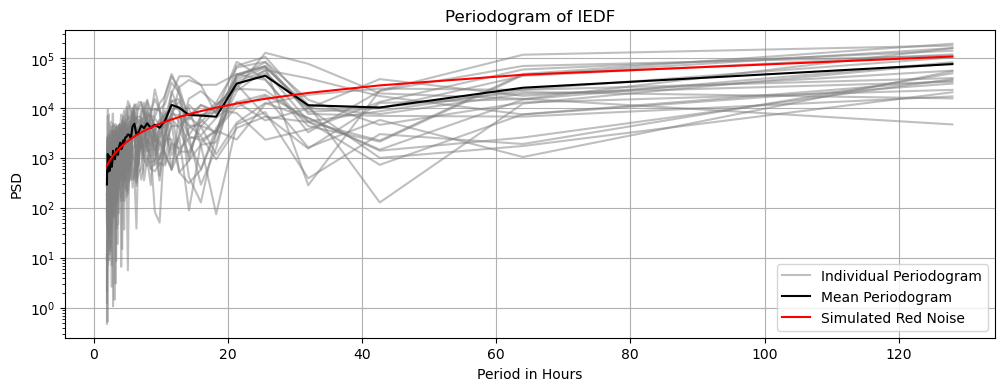

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

model = LinearRegression()


psd_totest = psdspikes[:,:,:,0]

# Assuming `psdspikes` is a 3D numpy array containing your data
# Initialize an array to store individual plots
individual_plots = []
freq = (1/(frequencies[1:]))/3600


plt.figure(figsize=(12, 4))

# Loop through each index i and plot psdspikes[i, 0, :]
for i in range(len(psdspikes)):
    to_plot = psd_totest[i, 0,1:]
    if i == 0:
        plt.semilogy(freq , to_plot, color='gray', alpha=0.5, label=f'Individual Periodogram')
    else:
        plt.semilogy(freq , to_plot, color='gray', alpha=0.5)
    individual_plots.append(to_plot)
    
    

# Calculate the mean of all individual plots
mean_plot = np.mean(individual_plots, axis=0)

# Plot the mean plot in black
plt.semilogy(freq , mean_plot, color='black', label='Mean Periodogram')



y = np.log(mean_plot)
x = np.log(freq )


model.fit(np.array(x).reshape(-1, 1),  y)


slope = model.coef_[0]
intercept = model.intercept_

predicted_values = model.predict(x.reshape(-1, 1))

# Calculate residuals
residuals = y - predicted_values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, predicted_values)



best_fit = np.exp(slope * x + intercept)


plt.semilogy(np.exp(x), best_fit, color='red', label='Simulated Red Noise')

#psd_ind = psd_totest[0, 0,1:]
#psd_ind_diff = np.log(best_fit[0]) - np.log(psd_ind[0])

# Simulate a line with uncertainty (using MSE)

simulated_line = [slope * xi + np.random.normal(0, np.sqrt(mse)) + intercept for xi in x]



#plt.semilogy(np.exp(x), np.exp(simulated_line), color='green', label = 'Simulated Distribution')

#to_track = np.zeros((100,))
#for i in range(100):
#    simulated_line = [slope * xi + np.random.normal(0, np.sqrt(mse)) + intercept for xi in x]
#    if simulated_line[4] > np.log(mean_plot[4]):
#        to_track[i] = 1
#    else:
#        to_track[i] = 0
    
#print(np.sum(to_track))




# Add labels, legend, and other plot customizations as needed
plt.xlabel('Period in Hours')
plt.ylabel('PSD')
plt.title('Periodogram of IEDF')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()






In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


def calc_prob(psd, freq):
    

    model = LinearRegression()

    # Calculate the mean of all individual plots
    mean_plot = np.mean(psd, axis=0)

    # Plot the mean plot in black



    y = np.log(mean_plot)
    x = np.log(freq )


    model.fit(np.array(x).reshape(-1, 1),  y)


    slope = model.coef_[0]
    intercept = model.intercept_

    predicted_values = model.predict(x.reshape(-1, 1))

    # Calculate residuals
    residuals = y - predicted_values

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predicted_values)
    
    
    best_fit = np.exp(slope * x + intercept)
    psd_ind_diff = np.array([np.log(best_fit[0]) - np.log(psd_[0]) for psd_ in psd])
    to_track = np.zeros((len(psd),1000))

    for i in range(len(psd)):
        for j in range(1000):
            simulated_line = [slope * xi + np.random.normal(0, np.sqrt(mse)) + intercept - psd_ind_diff[i]  for xi in x]
            if simulated_line[4] > np.log(psd[i,4]):
                to_track[i,j] = 1
            else:
                to_track[i,j] = 0
    mm = np.mean(to_track, axis =1)
    dd = np.sum(np.array(mm) < 0.05)/len(mm)
    return dd



In [20]:
auto_per = calc_prob(psdauto[:,8,0,1:, 0],frequencies[1:])
var_per = calc_prob(psdvar[:,4,0,1:, 0],frequencies[1:])
syn_per = calc_prob(psdsyn[:,3,0,1:, 0],frequencies[1:])
spat_per = calc_prob(psddist[:,8,0,1:, 0],frequencies[1:])
spike_per = calc_prob(psdspikes[:,0,1:, 0],frequencies[1:])

In [56]:
autopsd = [calc_prob(psdauto[:,xxx,0,1:,0], frequencies[1:]) for xxx in range(10)] 
varpsd = [calc_prob(psdvar[:,xxx,0,1:,0], frequencies[1:]) for xxx in range(10)] 
synpsd = [calc_prob(psdsyn[:,xxx,0,1:,0], frequencies[1:]) for xxx in range(10)] 
scmpsd = [calc_prob(psddist[:,xxx,0,1:,0], frequencies[1:]) for xxx in range(10)] 


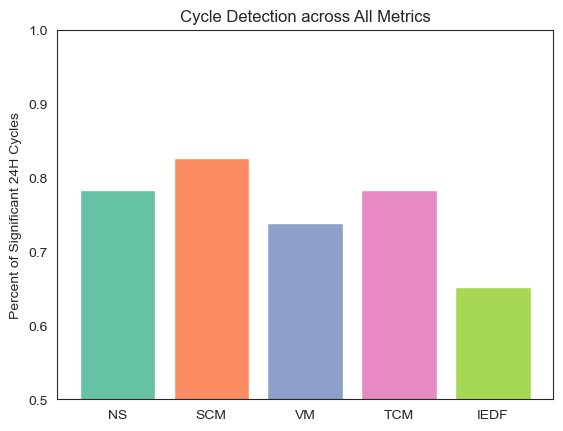

In [21]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
values = [syn_per, spat_per, var_per, auto_per, spike_per]
labels = ['NS', 'SCM', 'VM', 'TCM', 'IEDF']

#sns.set_style("whitegrid")
sns.set_style("white")
colors = sns.color_palette("Set2")

# Create the bar plot
plt.bar(labels, values, color=colors)

# Add labels and title
plt.xlabel('')
plt.ylabel('Percent of Significant 24H Cycles')
plt.title('Cycle Detection across All Metrics')
plt.ylim([0.5,1])
# Show the plot
plt.show()


In [42]:
import numpy as np
from joblib import Parallel, delayed

fracsspikes = np.zeros((11, 100))

def calculate_probabilities(i):
    return [calc_prob(psdvar[:, 4, j, 1:, i], frequencies[1:]) for j in range(11)]

result = Parallel(n_jobs=-1)(delayed(calculate_probabilities)(i) for i in range(100))



(0.3, 1.0)

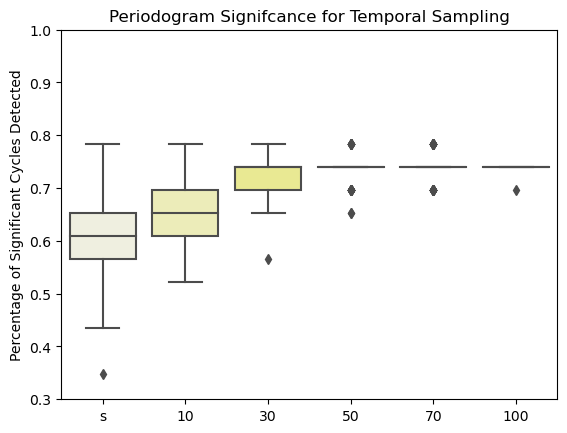

In [57]:
import seaborn as sns


d1 = fracdist[1,:].flatten()
d2 = fracdist[2,:].flatten()
d3 = fracdist[3,:].flatten()
d4 = fracdist[4,:].flatten()
d5 = fracdist[5,:].flatten()
d6 = fracdist[0,:].flatten()

# Define the base color (e.g., blue)
base_color = 'yellow'

# Create a custom color palette with graded shades
num_shades = 6
color_palette = [sns.light_palette(base_color, n_colors=num_shades)[i] for i in range(num_shades)]

# Create a Seaborn box plot with the custom color palette
sns.set_palette(color_palette)



ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6])#,  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['s','10', '30', '50', '70', '100']


ax.set_xticklabels(labels)
plt.ylabel("Percentage of Significant Cycles Detected")

plt.title("Periodogram Signifcance for Temporal Sampling")
plt.ylim([0.3,1])






C:\Users\amrit\AppData\Local\Temp\ipykernel_19608\2780378084.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(hours)


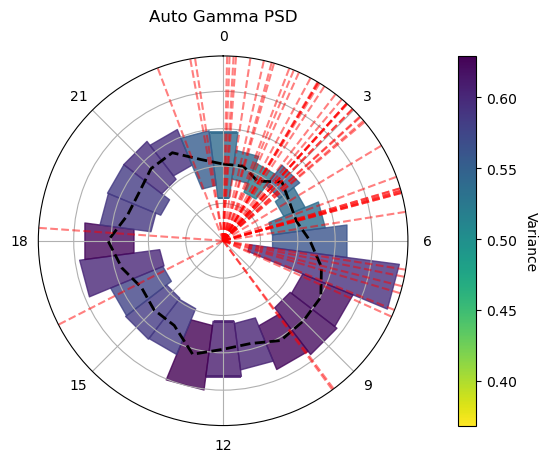

In [8]:

hourly_mean = df.groupby('hour')['autogamma_psd'].median()
hourly_std = df.groupby('hour')['autogamma_psd'].std()
clockplot( hourly_mean, hourly_std ,onset_dt, 'Auto Gamma PSD', 'Variance')

In [12]:
mytest = 'spike'
yaxis = 'spike per min'

mask = identify_outliers(df, mytest)
df = df[mask]

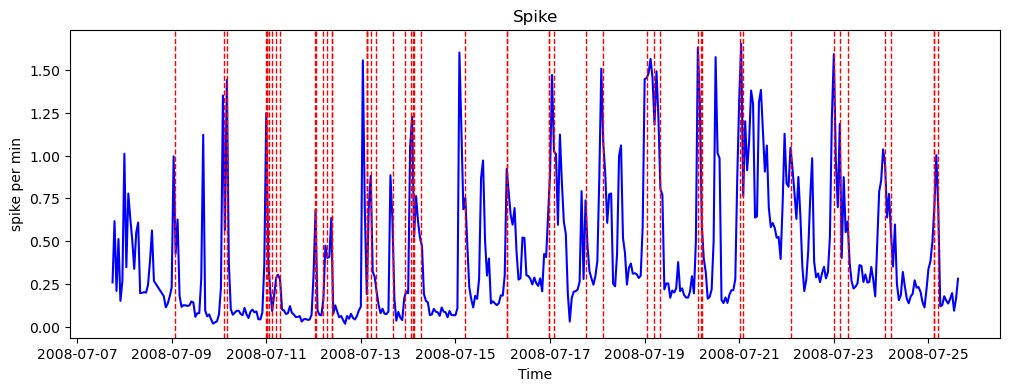

In [13]:
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import hilbert

# Assuming you have a DataFrame 'df' with columns 'datetime_column' and 'spike'
# Example DataFrame creation:
# df = pd.DataFrame({'datetime_column': your_datetime_data, 'spike': your_spike_data})

# Convert datetime_column to seconds
df['time_seconds'] = (df['datetime_column'] - df['datetime_column'].min()).dt.total_seconds()

# Define a regular time grid with one-hour intervals based on your data
t_regular = pd.date_range(start=df['datetime_column'].min(), end=df['datetime_column'].max(), freq='1H')

# Convert regular time grid to seconds
t_regular_seconds = (t_regular - t_regular.min()).total_seconds()

# Interpolate the 'spike' column to the regular time grid using seconds
interpolator = interp1d(df['time_seconds'], df[mytest], kind='linear', fill_value='extrapolate')
spike_regular = interpolator(t_regular_seconds)

plt.figure(figsize=(12, 4))
plt.plot(t_regular, spike_regular, label=f'{mytest}', color = 'blue')

plt.title('Spike')
plt.xlabel('Time')
plt.ylabel(yaxis)

#plt.legend()



#Add vertical red lines at the onset_dt points
for onset in onset_dt:
    plt.axvline(x=onset, color='red', linestyle='--', linewidth=1)

plt.show()


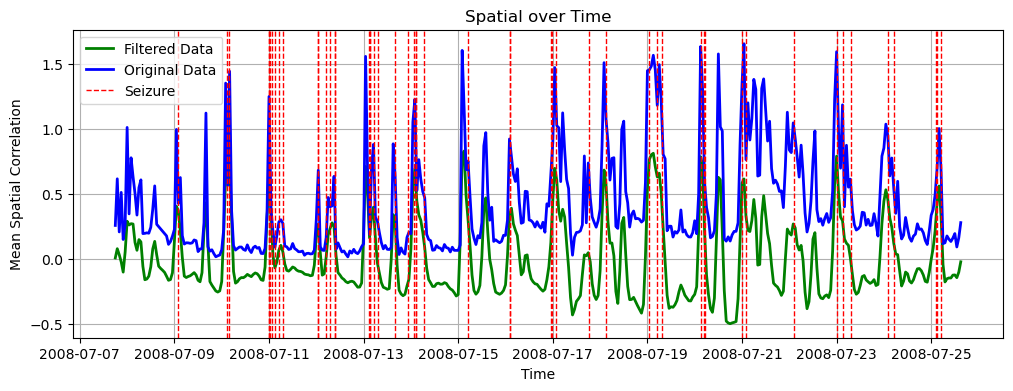

In [101]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

# Sample data (replace this with your own data)
time = t_regular
data = spike_regular
# Define the sampling frequency (one sample per hour)
fs = 1.0 / 3600.0  # Sampling frequency in samples per second (1/3600 hours)

# Define the desired cutoff frequencies as fractions of the Nyquist frequency
lowcut = 1.0 / 30.0  # Lower cutoff frequency for 24 hours
highcut = 1.0 / 2.0  # Upper cutoff frequency for 12 hours

order = 1

# Design the bandpass filter using Butterworth filter design
b, a = signal.butter(order, [lowcut, highcut], btype="band")

# Apply the bandpass filter to your data
#filtered_data = signal.lfilter(b, a, data)

filtered_data = signal.filtfilt(b, a, data, padtype='constant', padlen=50)  # Adjust padlen as needed


#scaler = StandardScaler()
#normalized_data = scaler.fit_transform(filtered_data.reshape(-1, 1))

# Plot the original and filtered data
plt.figure(figsize=(12, 4))
#plt.plot(time, data, "b-", label="Original Data")
plt.plot(time, filtered_data, "g-", linewidth=2, label="Filtered Data")
plt.plot(time, spike_regular, "b-", linewidth=2, label="Original Data")
plt.title('Spatial over Time')
plt.xlabel('Time')
plt.ylabel('Mean Spatial Correlation')

plt.grid(True)

# Add vertical red lines at the onset_dt points

ccc =0
for onset in onset_dt:
    if ccc == 0:
        plt.axvline(x=onset, color='red', linestyle='--', linewidth=1, label = "Seizure")
    else:
        plt.axvline(x=onset, color='red', linestyle='--', linewidth=1)
    ccc = 1


plt.legend()
plt.show()


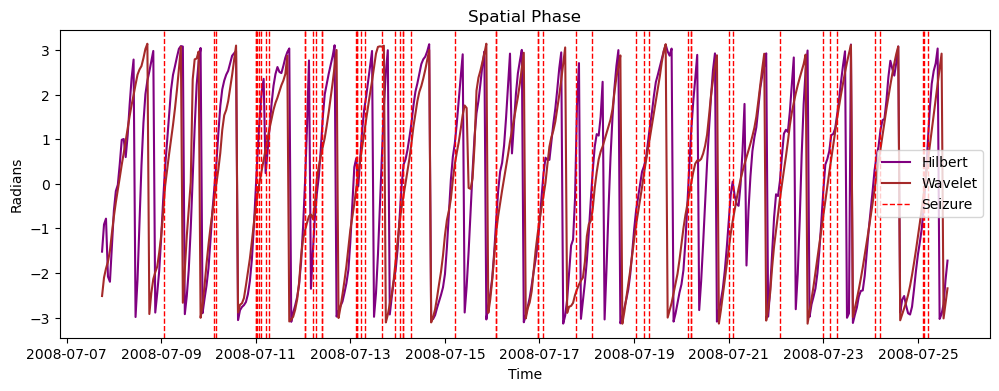

In [120]:
# Perform the Hilbert transform on the regularly sampled 'spike' data
#analytic_signal = hilbert(normalized_data)

# Calculate the phase of the analytic signal
hilbert_phase = myphase(filtered_data)


mother_wavelet = 'cmor'  # Complex Morlet wavelet
frequency = 24*fs  # Frequency corresponding to 6 hours (in 1/hour units)
num_scales = 10  # Number of scales for decomposition

coefficients, frequencies = pywt.cwt(filtered_data, np.arange(1, num_scales+1), mother_wavelet, sampling_period=1/fs)

# Compute phase information
wavphase = np.angle(coefficients)
wavphase = wavphase[9]



# Plot the phase
plt.figure(figsize=(12, 4))
plt.plot(t_regular, hilbert_phase, label='Hilbert', color = 'purple')
plt.plot(t_regular, wavphase, label='Wavelet', color = 'brown')


plt.title(f'Spatial Phase')
plt.xlabel('Time')
plt.ylabel('Radians')




ccc =0
for onset in onset_dt:
    if ccc == 0:
        plt.axvline(x=onset, color='red', linestyle='--', linewidth=1, label = "Seizure")
    else:
        plt.axvline(x=onset, color='red', linestyle='--', linewidth=1)
    ccc = 1
    
plt.legend()    
plt.show()


In [121]:
reference_time =  t_regular.min()
onset_seconds = [(dt - reference_time).total_seconds() for dt in onset_dt]
time_seconds = [(dt - reference_time).total_seconds() for dt in t_regular]
# Initialize an array to store the interpolated phase values
interpolated_phase = np.interp(onset_seconds, time_seconds, hilbert_phase)


# Calculate the sum of e^(i*interpolated_phase) for each onset datetime point
result_sum = np.sum(np.exp(1j * interpolated_phase))

# Calculate the phase locking value (PLV)
plv = np.abs(np.real(result_sum / len(onset_dt)))

print("PLV:", plv)

PLV: 0.6787663853388458


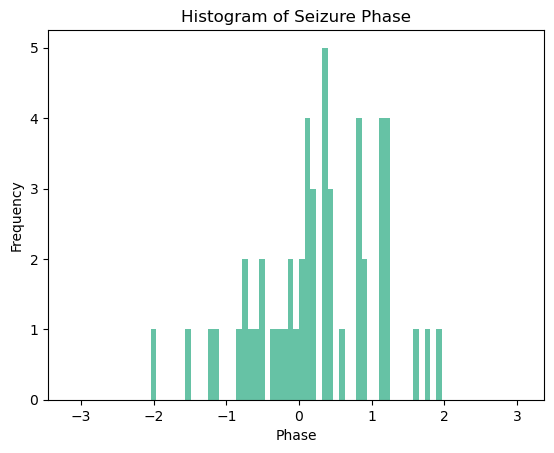

In [49]:
sns.set_palette("Set2")

bins = np.arange(-np.pi, np.pi, np.pi/40)

# Create the histogram
plt.hist(interpolated_phase, bins=bins)
# Set labels and title
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Histogram of Seizure Phase')

# Show the plot
plt.show()



# Create the histogram


hist, bin_edges = np.histogram(interpolated_phase, bins=bins)
# Find the bin with the maximum frequency
most_common_bin_index = np.argmax(hist)

# Calculate the most common phase value based on bin boundaries
most_common_phase = (bin_edges[(most_common_bin_index - 2) % len(bin_edges)] + bin_edges[(most_common_bin_index + 2) % len(bin_edges)]) / 2



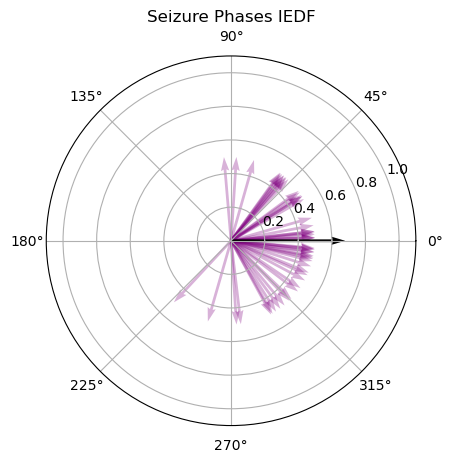

In [52]:

# Convert the phases to complex numbers
complex_numbers = np.exp(1j * interpolated_phase)

# Calculate the average phase
average_phase = np.angle(np.mean(complex_numbers))

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_ylim(0, 1.1)  # Set the radial range from 0 to 1.2



for phase in interpolated_phase:
    magnitude = 0.5  # You can adjust the magnitude of the vectors
    ax.quiver(0, 0, np.angle(np.exp(1j * phase)), magnitude, angles='xy', scale_units='xy', scale=1, color='purple', alpha=0.3)

# Plot a black line for the average phase

mymag = plv
toadd = 0 if np.real(np.exp(1j * average_phase)) > 0 else 1
myangle = np.angle(np.exp(1j * average_phase))


ax.quiver(0, 0, myangle, mymag, angles='xy', scale_units='xy', scale=1, color='black', alpha=1)

# Set the title
plt.title('Seizure Phases IEDF')

# Show the plot
plt.show()

Text(0.5, 1.0, 'PLV across TCM')

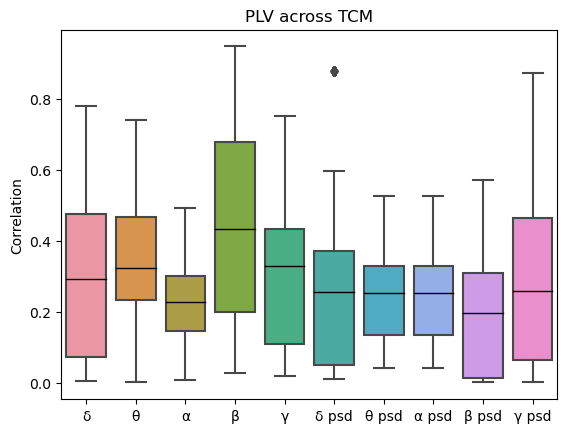

In [49]:
sns.set_palette("Set2")

data = plvauto[:,:,:]



ax = sns.boxplot(data = [ data[:,4,0] , data[:,0,0] , data[:,1,0] , data[:,2,0] , data[:,3,0] ,  data[:,9,0], data[:,5,0] , data[:,6,0], data[:,7,0], data[:,8,0]],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = [ 'δ', 'θ', 'α', 'β', 'γ', 'δ psd', 'θ psd', 'α psd', 'β psd', 'γ psd', ]


ax.set_xticklabels(labels)
plt.ylabel("Correlation")
plt.title("PLV across TCM")


Text(0.5, 1.0, 'PLV across VM')

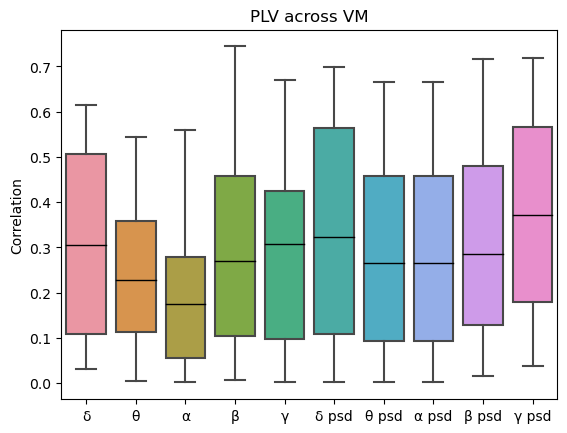

In [48]:
sns.set_palette("Set2")

data = plvvar[:,:,:]



ax = sns.boxplot(data = [ data[:,4,0] , data[:,0,0] , data[:,1,0] , data[:,2,0] , data[:,8,0] ,  data[:,9,0], data[:,5,0] , data[:,6,0], data[:,7,0], data[:,3,0]],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = [ 'δ', 'θ', 'α', 'β', 'γ', 'δ psd', 'θ psd', 'α psd', 'β psd', 'γ psd', ]


ax.set_xticklabels(labels)
plt.ylabel("Correlation")
plt.title("PLV across VM")


Text(0.5, 1.0, 'PLV across SCM')

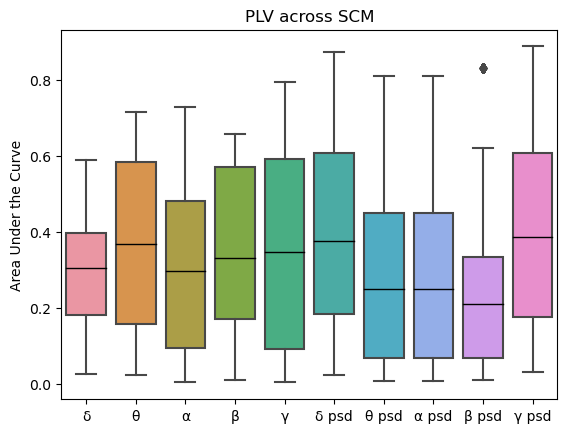

In [19]:
sns.set_palette("Set2")

data = plvsyn



ax = sns.boxplot(data = [ data[:,4,0] , data[:,0,0] , data[:,1,0] , data[:,2,0] , data[:,3,0] ,  data[:,9,0], data[:,5,0] , data[:,6,0], data[:,7,0], data[:,8,0]],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = [ 'δ', 'θ', 'α', 'β', 'γ', 'δ psd', 'θ psd', 'α psd', 'β psd', 'γ psd', ]


ax.set_xticklabels(labels)
plt.ylabel("Area Under the Curve")
plt.title("PLV across SCM")


Text(0.5, 1.0, 'PLV across NS')

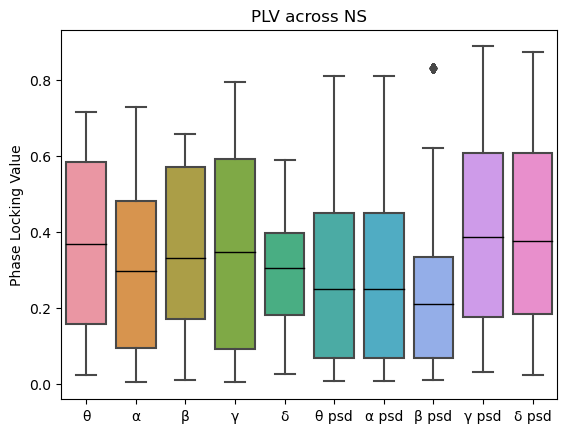

In [46]:
sns.set_palette("Set2")

data = plvsyn



ax = sns.boxplot(data = [ data[:,0,0] , data[:,1,0] , data[:,2,0] , data[:,3,0] , data[:,4,0] , data[:,5,0] , data[:,6,0], data[:,7,0], data[:,8,0], data[:,9,0]],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['θ', 'α', 'β', 'γ', 'δ', 'θ psd', 'α psd', 'β psd', 'γ psd', 'δ psd']


ax.set_xticklabels(labels)
plt.ylabel("Phase Locking Value")
plt.title("PLV across NS")


(0.0, 1.0)

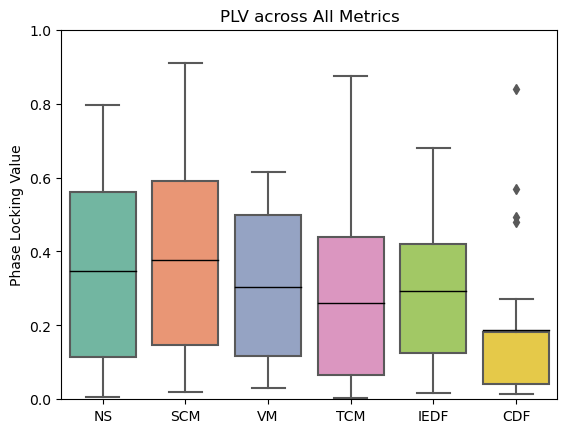

In [12]:

d5 = plvspikes[:,0,0]
d1 = plvsyn[:,3,0,0]
d2 = plvdist[:,8,0,0]
d3 = plvvar[:,4,0,0]
d4 = plvauto[:,8,0,0]
d6 = plvcos[:,0]

sns.set_palette("Set2")




ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})
#ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6] )



labels = ['NS', 'SCM', 'VM', 'TCM', 'IEDF', 'CDF']


ax.set_xticklabels(labels)
plt.ylabel("Phase Locking Value")
plt.title("PLV across All Metrics")
plt.ylim([0,1])

Text(0.5, 1.0, 'AED across All Metrics')

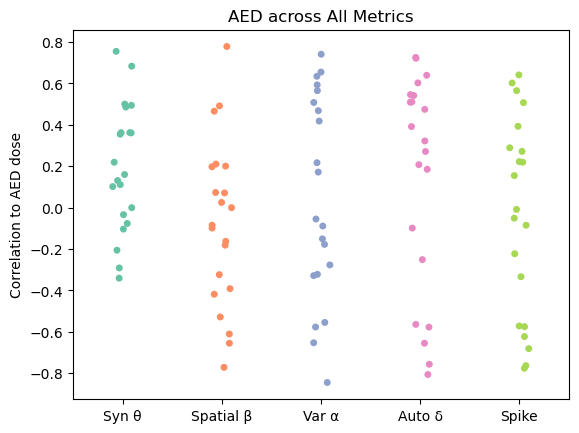

In [83]:

d = [aedsyn[:, 0, 0], aeddist[:, 2, 0], aedvar[:, 1, 0], aedauto[:, 4, 0], aedspikes[:, 0]]
labels = ['Syn θ', 'Spatial β', 'Var α', 'Auto δ', 'Spike']

sns.set_palette("Set2")

ax = sns.stripplot(data=d)

ax.set_xticklabels(labels)
plt.ylabel("Correlation to AED dose")
plt.title("AED across All Metrics")

In [25]:
import scipy
data_test_labels = [ 'syngamma', 'distgamma_psd',  'varbroad',  'autogamma_psd', 'spike']



correlation_matrix = np.zeros((len(allpats),6,6))
pvalue_matrix = np.zeros((len(allpats),6,6))

data_list = []


for a_label in data_test_labels:
    tmp_list = []
    for a_df in df_list:
        d1 = a_df[a_label]
        tmp_list.append(d1)
    
    data_list.append(np.hstack(tmp_list))

In [26]:
corr, pvals  = scipy.stats.spearmanr(np.transpose(data_list))

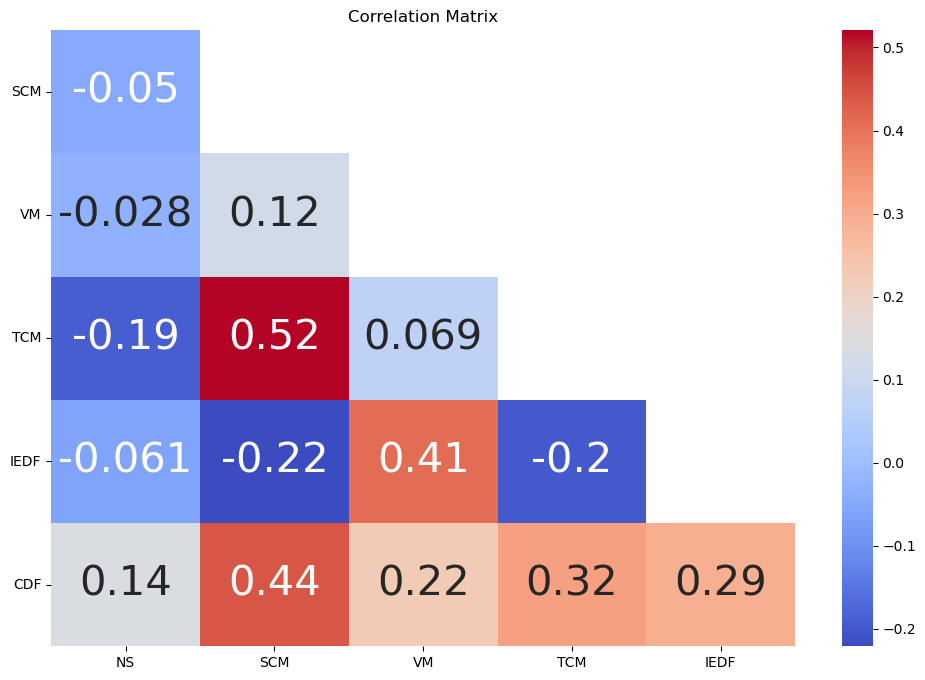

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Calculate the correlation matrix
corr_matrix = np.mean(correlation_matrix, axis =0)

sig = np.zeros((6,6))

for i in range(6):
    for j in range(6):
        sig[i,j] = np.sum([1 if pvalue_matrix[x,i,j] < 0.002 else 0 for x in range(23)])/23
        
        

# Create a mask to hide the upper triangular part of the matrix (including the diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Create a heatmap of the correlation matrix with the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, ax=ax, annot_kws={"fontsize":30})



labels =  ['NS', 'SCM', 'VM', 'TCM', 'IEDF', 'CDF']

#labels = data_test_labels 
# Customize the plot (optional)
plt.title('Correlation Matrix')
plt.xticks(np.arange(6) + 0.5, labels, rotation=0)
plt.yticks(np.arange(6) + 0.5, labels, rotation=0)

plt.xlim([0,5])
plt.ylim([6,1])


# Show the plot
plt.show()

In [91]:
import numpy as np
from scipy.stats import spearmanr


def cosine_daily_corr(df, mytest):
    datetime_index = df.datetime_column

    # Define the range of phase values from 0 to 2*pi with pi/20 intervals
    phase_values = np.arange(0, 2 * np.pi, np.pi / 1000)

    # Initialize variables to store the maximum correlation and corresponding phase
    max_correlation = 0
    p_val = 1

    # Calculate the cosine values at the same timestamps
    frequency = 2 * np.pi / 24  # Frequency for hourly oscillation (1 cycle in 24 hours)
    amplitude = 1.0  # Amplitude of the cosine wave

    for phase in phase_values:
        # Calculate the cosine values at the same timestamps as df_cosine
        cosine_values = amplitude * np.cos(frequency * np.arange(len(datetime_index)) + phase)

        # Calculate the correlation between 'auto' and the generated cosine values
        correlation, pp = spearmanr(df[mytest], cosine_values)
        #correlation = np.corrcoef(df[mytest], cosine_values)[0]

        # Update the maximum correlation and optimal phase
        if np.abs(correlation) > np.abs(max_correlation):
            max_correlation = correlation
            p_val = pp 

    
    return max_correlation, pp

(0.4, 1.0)

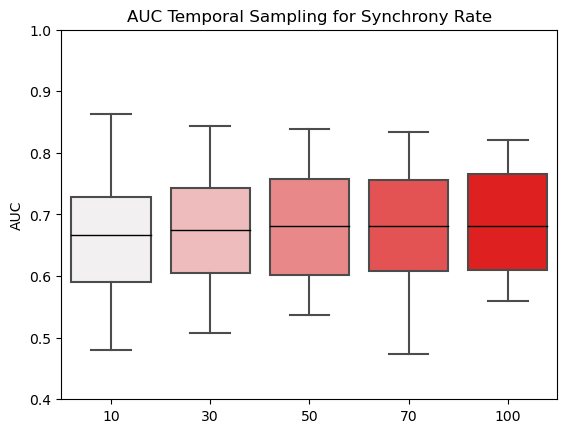

In [113]:
np.shape(aucvar)

data = aucsyn
mytest = 8


d1 = data[:,mytest, 5,:].flatten()
d2 = data[:,mytest, 6,:].flatten()
d3 = data[:,mytest, 7,:].flatten()
d4 = data[:,mytest, 8,:].flatten()
d5 = data[:,mytest, 0,:].flatten()

# Define the base color (e.g., blue)
base_color = 'red'

# Create a custom color palette with graded shades
num_shades = 5
color_palette = [sns.light_palette(base_color, n_colors=num_shades)[i] for i in range(num_shades)]

# Create a Seaborn box plot with the custom color palette
sns.set_palette(color_palette)



ax = sns.boxplot(data = [d1, d2, d3, d4, d5],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['10', '30', '50', '70', '100']


ax.set_xticklabels(labels)
plt.ylabel("AUC")

plt.title("AUC Temporal Sampling for Synchrony Rate")
plt.ylim([0.4, 1])






Text(0.5, 1.0, 'AUC across Temporal Sampling for Synchrony')

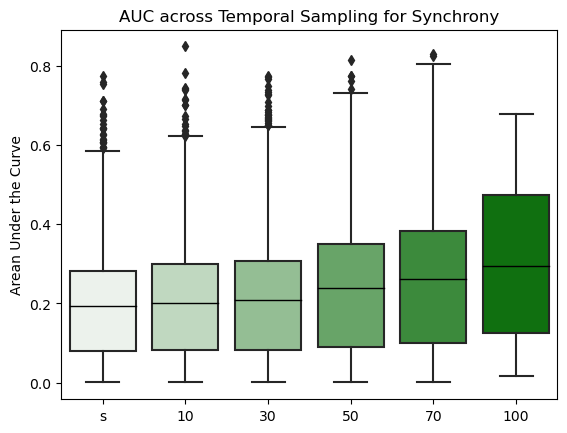

In [86]:


data = plvspikes
mytest = 8


d1 = data[:,1,:].flatten()
d2 = data[:,2,:].flatten()
d3 = data[:,3,:].flatten()
d4 = data[:,4,:].flatten()
d5 = data[:,5,:].flatten()
d6 = data[:,0,:].flatten()

# Define the base color (e.g., blue)
base_color = 'green'

# Create a custom color palette with graded shades
num_shades = 6
color_palette = [sns.light_palette(base_color, n_colors=num_shades)[i] for i in range(num_shades)]

# Create a Seaborn box plot with the custom color palette
sns.set_palette(color_palette)


ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['s','10', '30', '50', '70', '100']


ax.set_xticklabels(labels)
plt.ylabel("Arean Under the Curve")

plt.title("AUC across Temporal Sampling for Synchrony")





Text(0.5, 1.0, 'PLV across Temporal Sampling for VM')

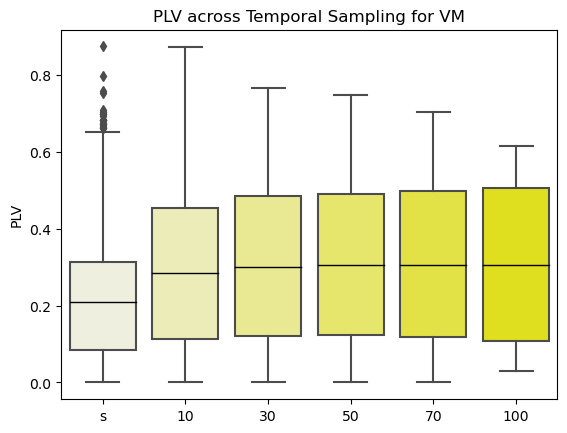

In [71]:


data = plvvar
mytest = 4


d1 = data[:,mytest,1,:].flatten()
d2 = data[:,mytest,2,:].flatten()
d3 = data[:,mytest,3,:].flatten()
d4 = data[:,mytest,4,:].flatten()
d5 = data[:,mytest,5,:].flatten()
d6 = data[:,mytest,0,:].flatten()

# Define the base color (e.g., blue)
base_color = 'yellow'

# Create a custom color palette with graded shades
num_shades = 6
color_palette = [sns.light_palette(base_color, n_colors=num_shades)[i] for i in range(num_shades)]

# Create a Seaborn box plot with the custom color palette
sns.set_palette(color_palette)


ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['s','10', '30', '50', '70', '100']


ax.set_xticklabels(labels)
plt.ylabel("PLV")

plt.title("PLV across Temporal Sampling for VM")





Text(0.5, 1.0, 'AUC across Temporal Sampling for Spikes')

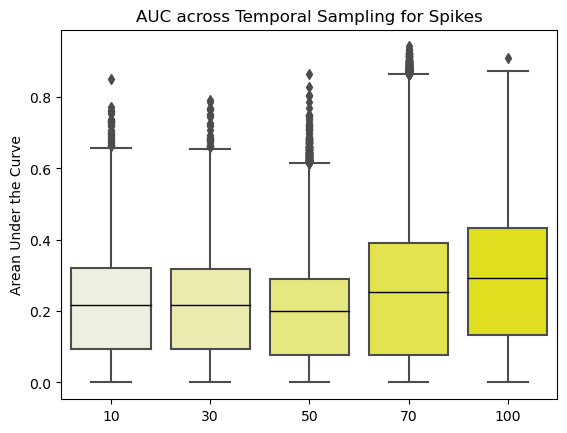

In [66]:
np.shape(aucvar)

data = plvauto
mytest = 8


d1 = data[:,5,:].flatten()
d2 = data[:,6,:].flatten()
d3 = data[:,7,:].flatten()
d4 = data[:,8,:].flatten()
d5 = data[:,0,:].flatten()

# Define the base color (e.g., blue)
base_color = 'yellow'

# Create a custom color palette with graded shades
num_shades = 5
color_palette = [sns.light_palette(base_color, n_colors=num_shades)[i] for i in range(num_shades)]

# Create a Seaborn box plot with the custom color palette
sns.set_palette(color_palette)



ax = sns.boxplot(data = [d1, d2, d3, d4, d5],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['10', '30', '50', '70', '100']


ax.set_xticklabels(labels)
plt.ylabel("Arean Under the Curve")

plt.title("AUC across Temporal Sampling for Spikes")







Text(0.5, 1.0, 'PLV across All Metrics')

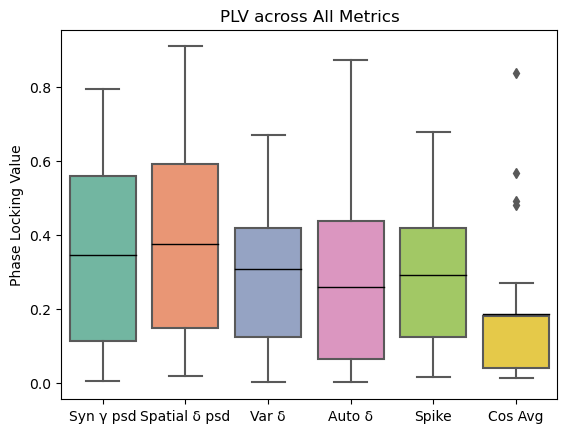

In [22]:

d5 = plvspikes[:,0,0]
d1 = plvsyn[:,3,0,0]
d2 = plvdist[:,8,0,0]
d3 = plvvar[:,8,0,0]
d4 = plvauto[:,8,0,0]
d6 = plvcos[:,0]

sns.set_palette("Set2")




ax = sns.boxplot(data = [d1, d2, d3, d4, d5, d6],  showmeans= True, meanline=True,  medianprops={"visible": False}, meanprops={"color": "black", "linestyle": "-"})


labels = ['Syn γ psd', 'Spatial δ psd', 'Var δ', 'Auto δ', 'Spike', 'Cos Avg']


ax.set_xticklabels(labels)
plt.ylabel("Phase Locking Value")

plt.title("PLV across All Metrics")
